# Goal

* A basic, full run of the SIPSim pipeline with the whole bacterial genome dataset to see:
  * Is the pipeline functional?
  * Check of output at each stage of pipeline

# Setting variables

In [261]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/'
genomeDir = '/var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'
figureDir = '/home/nick/notebook/SIPSim/figures/bac_genome_n1147/'

bandwidth = 0.8
DBL_scaling = 0.5
subsample_dist = 'lognormal'
subsample_mean = 9.432
subsample_scale = 0.5
subsample_min = 10000
subsample_max = 30000

# Init

In [262]:
import glob
from os.path import abspath
import nestly
from IPython.display import Image
import os
%load_ext rpy2.ipython
%load_ext pushnote

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The pushnote extension is already loaded. To reload it, use:
  %reload_ext pushnote


In [263]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

In [264]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
if not os.path.isdir(figureDir):
    os.makedirs(figureDir)    
    
%cd $workDir    

/home/nick/notebook/SIPSim/dev/bac_genome1147/validation


In [265]:
# Determining min/max BD that 
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_range_BD = min_GC/100.0 * 0.098 + 1.66    
max_range_BD = max_GC/100.0 * 0.098 + 1.66    

max_range_BD = max_range_BD + max_13C_shift_in_BD

print 'Min BD: {}'.format(min_range_BD)
print 'Max BD: {}'.format(max_range_BD)

Min BD: 1.67323
Max BD: 1.7744


# Creating a community file

* 2 communities
  * control vs treatment

In [326]:
!SIPSim communities \
    $genomeDir/genome_index.txt \
    --n_comm 2 \
    > comm.txt

## Plotting community rank abundances

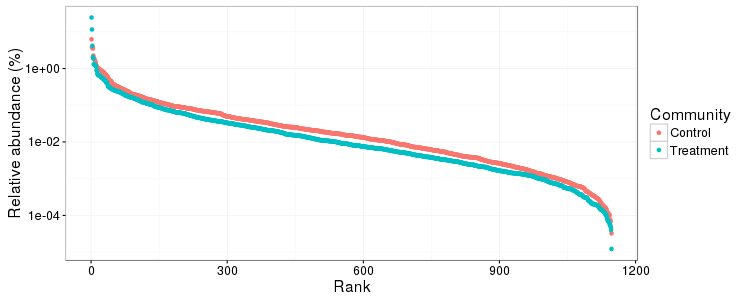

In [327]:
%%R -w 750 -h 300


tbl = read.delim('comm.txt', sep='\t')

tbl$library = as.character(tbl$library)
tbl$library = ifelse(tbl$library == 1, 'Control', 'Treatment')

ggplot(tbl, aes(rank, rel_abund_perc, color=library, group=taxon_name)) +
    geom_point() +
    scale_y_log10() +
    scale_color_discrete('Community') +
    labs(x='Rank', y='Relative abundance (%)') +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

# Simulating gradient fractions

In [328]:
!SIPSim gradient_fractions \
    --BD_min $min_range_BD \
    --BD_max $max_range_BD \
    comm.txt \
    > fracs.txt    

## Plotting fractions

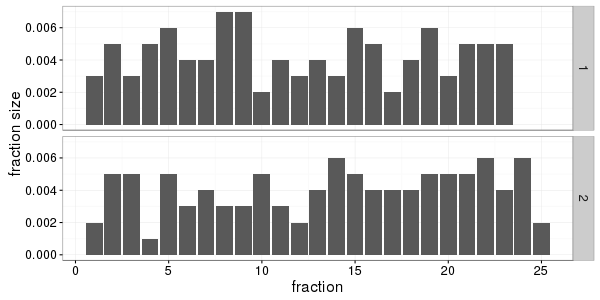

In [283]:
%%R -w 600 -h 300

tbl = read.delim('fracs.txt', sep='\t')

ggplot(tbl, aes(fraction, fraction_size)) +
    geom_bar(stat='identity') +
    facet_grid(library ~ .) +
    labs(y='fraction size') +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

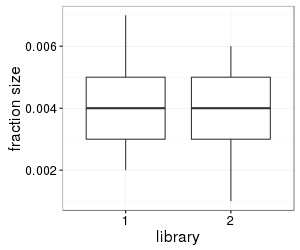

In [284]:
%%R -w 300 -h 250
tbl$library = as.character(tbl$library)

ggplot(tbl, aes(library, fraction_size)) +
    geom_boxplot() +
    labs(y='fraction size') +
    theme_bw() +
    theme(
        text=element_text(size=16)
        )

# Simulating fragments

In [9]:
# estimated coverage
mean_frag_size = 9000.0
mean_amp_len = 300.0
n_frags = 10000

coverage = round(n_frags * mean_amp_len / mean_frag_size, 1)
msg = 'Average coverage from simulating {} fragments: {}X'
print msg.format(n_frags, coverage)

Average coverage from simulating 10000 fragments: 333.3X


In [10]:
!SIPSim fragments \
    $genomeDir/genome_index.txt \
    --fp $genomeDir \
    --fr ../../515F-806R.fna \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np 24 \
    2> ampFrags.log \
    > ampFrags.pkl        

## Number of amplicons per taxon

In [285]:
!grep "Number of amplicons: " ampFrags.log | \
    perl -pe 's/.+ +//' | hist


 337|    o       
 319|    o       
 302|    o       
 284|    o       
 267|    o       
 249|    o       
 232|   oo       
 214|   oo       
 197|   oo       
 179|   oo       
 161|   oo o     
 144|   oo o     
 126|  ooo o     
 109|  ooo o     
  91|  ooooo     
  74|  ooooo     
  56|  ooooo     
  39| oooooo o   
  21| oooooooo   
   4| ooooooooooo
     -----------

------------------------------
|          Summary           |
------------------------------
|     observations: 1146     |
|    min value: 0.000000     |
|      mean : 3.823735       |
|    max value: 15.000000    |
------------------------------


In [286]:
!printf "Number of taxa with >=1 amplicon: "
!grep "Number of amplicons: " ampFrags.log | \
    perl -ne "s/^.+ +//; print unless /^0$/" | wc -l

Number of taxa with >=1 amplicon: 1101


# Converting fragments to kde object

In [287]:
!SIPSim fragment_KDE \
    ampFrags.pkl \
    > ampFrags_kde.pkl

## Checking ampfrag info

In [288]:
!SIPSim KDE_info -s ampFrags_kde.pkl \
    > ampFrags_kde_info.txt

Loading KDEs...


In [289]:
%%R 
# loading
df = read.delim('ampFrags_kde_info.txt', sep='\t')
df.kde1 = df %>%
    filter(KDE_ID == 1)
df.kde1 %>% head(n=3)

BD_GC50 = 0.098 * 0.5 + 1.66

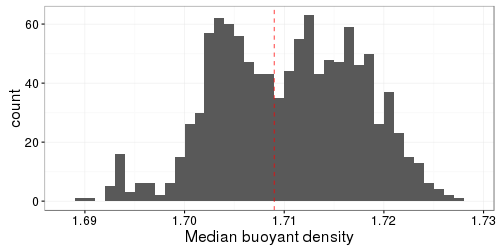

In [290]:
%%R -w 500 -h 250
# plotting
p.amp = ggplot(df.kde1, aes(median)) +
    geom_histogram(binwidth=0.001) +
    geom_vline(xintercept=BD_GC50, linetype='dashed', color='red', alpha=0.7) +
    labs(x='Median buoyant density') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.amp

# Adding diffusion

In [291]:
!SIPSim diffusion \
    ampFrags_kde.pkl \
    --bw $bandwidth \
    --np 24 \
    > ampFrags_kde_dif.pkl \
    2> ampFrags_kde_dif.log

# Adding DBL 'contamination'

* DBL = diffusive boundary layer

In [292]:
!SIPSim DBL \
    ampFrags_kde_dif.pkl \
    --comm comm.txt \
    --commx $DBL_scaling \
    --np 24 \
    > ampFrags_kde_dif_DBL.pkl \
    2> ampFrags_kde_dif_DBL.log
    
# checking output    
!tail ampFrags_kde_dif_DBL.log

Processing: Pararhodospirillum_photometricum_DSM_122
Processing: Gluconobacter_oxydans_621H
Processing: Dictyoglomus_thermophilum_H-6-12
Processing: Nocardia_farcinica_IFM_10152
Processing: Oscillatoria_acuminata_PCC_6304
Processing: Campylobacter_ureolyticus_RIGS_9880
Processing: Ruminococcus_albus_7_DSM_20455
Processing: Dyadobacter_fermentans_DSM_18053
Processing: Acidimicrobium_ferrooxidans_DSM_10331
Processing: Mycobacterium_africanum_GM041182


## Comparing DBL+diffusion to diffusion

In [293]:
# none
!SIPSim KDE_info \
    -s ampFrags_kde.pkl \
    > ampFrags_kde_info.txt
    
# diffusion
!SIPSim KDE_info \
    -s ampFrags_kde_dif.pkl \
    > ampFrags_kde_dif_info.txt
    
# diffusion + DBL    
!SIPSim KDE_info \
    -s ampFrags_kde_dif_DBL.pkl \
    > ampFrags_kde_dif_DBL_info.txt

Loading KDEs...
Loading KDEs...
Loading KDEs...


In [294]:
%%R 

inFile = 'ampFrags_kde_info.txt'
df.raw = read.delim(inFile, sep='\t')
df.raw$stage = 'raw'

inFile = 'ampFrags_kde_dif_info.txt'
df.dif = read.delim(inFile, sep='\t')
df.dif$stage = 'diffusion'

inFile = 'ampFrags_kde_dif_DBL_info.txt'
df.DBL = read.delim(inFile, sep='\t')
df.DBL$stage = 'diffusion +\nDBL'

df = rbind(df.raw, df.dif, df.DBL)
df.dif = ''
df.DBL = ''
df %>% head(n=3)

  lib_ID                      taxon_ID KDE_ID        min percentile_5
1      1 Tropheryma_whipplei_str_Twist      1   1.706507     1.707309
2      1 Tropheryma_whipplei_str_Twist      2 315.000000  4095.000000
3      1   Caldisericum_exile_AZM16c01    NaN        NaN          NaN
  percentile_25        mean      median percentile_75 percentile_95
1      1.708236    1.709715    1.709811      1.710707      1.712784
2   6099.000000 7032.716600 7309.000000   8224.000000   9078.100000
3           NaN         NaN         NaN           NaN           NaN
           max        stdev stage
1     1.718544 1.665025e-03   raw
2 10547.000000 1.564348e+03   raw
3          NaN          NaN   raw


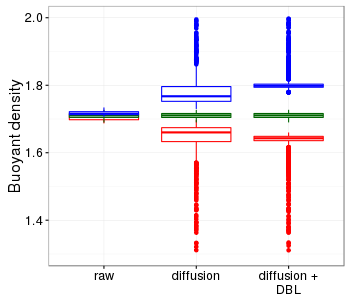

In [295]:
%%R -w 350 -h 300

df$stage = factor(df$stage, levels=c('raw', 'diffusion', 'diffusion +\nDBL'))

ggplot(df, aes(stage)) +
    geom_boxplot(aes(y=min), color='red') +
    geom_boxplot(aes(y=median), color='darkgreen') +
    geom_boxplot(aes(y=max), color='blue') +
    scale_y_continuous(limits=c(1.3, 2)) +
    labs(y = 'Buoyant density') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank()
    )

# Making an incorp config file

* 10% of taxa with 100% atom excess 13C

In [296]:
!SIPSim incorpConfigExample \
    --percTaxa 10 \
    --percIncorpUnif 100 \
    > PT10_PI100.config
    
# checking output
!head PT10_PI100.config


[1]
    # baseline: no incorporation
    treatment = control
    
    [[intraPopDist 1]]
        distribution = uniform
        
        [[[start]]]
            


# Adding isotope incorporation to BD distribution

In [297]:
!SIPSim isotope_incorp \
    ampFrags_kde_dif_DBL.pkl \
    PT10_PI100.config \
    --comm comm.txt \
    --np 24 \
    --shift ampFrags_BD-shift.txt \
    > ampFrags_kde_dif_DBL_incorp.pkl \
    2> ampFrags_kde_dif_DBL_incorp.log
    
# checking log
!tail -n 5 ampFrags_kde_dif_DBL_incorp.log

Processing: Tepidanaerobacter_acetatoxydans_Re1
Processing: Dichelobacter_nodosus_VCS1703A
Processing: Desulfobacca_acetoxidans_DSM_11109
Processing: Weissella_koreensis_KACC_15510
File written: ampFrags_BD-shift.txt


# Plotting stats on BD shift from isotop incorporation

In [298]:
%%R
inFile = 'ampFrags_BD-shift.txt'
df = read.delim(inFile, sep='\t') %>%
    mutate(library = library %>% as.character)

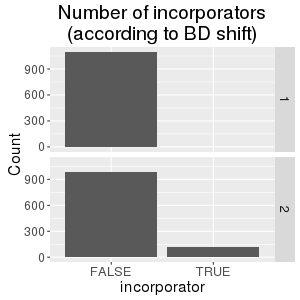

In [299]:
%%R -h 300 -w 300

inFile = 'ampFrags_BD-shift.txt'
df = read.delim(inFile, sep='\t') %>%
    mutate(library = library %>% as.character)

df.s = df %>% 
    mutate(incorporator = ifelse(min > 0.0001, TRUE, FALSE),
           incorporator = ifelse(is.na(incorporator), 'NA', incorporator)) %>%
    group_by(library, incorporator) %>%
    summarize(n_incorps = n())

ggplot(df.s, aes(incorporator, n_incorps)) +
    geom_bar(stat='identity') +
    labs(y = 'Count', title='Number of incorporators\n(according to BD shift)') +
    facet_grid(library ~ .) +
    theme(
        text = element_text(size=16)
    )


# Simulating an OTU table

In [300]:
!SIPSim OTU_table \
    ampFrags_kde_dif_DBL_incorp.pkl \
    comm.txt \
    fracs.txt \
    --abs 1e9 \
    --np 20 \
    > OTU_n2_abs1e9.txt \
    2> OTU_n2_abs1e9.log 
    
# checking log
!tail -n 5 OTU_n2_abs1e9.log 

   taxon abs-abundance:  12585521
  Processing taxon: "Selenomonas_sputigena_ATCC_35185"
   taxon abs-abundance:  12355629
  Processing taxon: "Beijerinckia_indica_subsp_indica_ATCC_9039"
   taxon abs-abundance:  11441139


## Plotting taxon abundances

In [301]:
%%R
## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp50 = 0.5 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

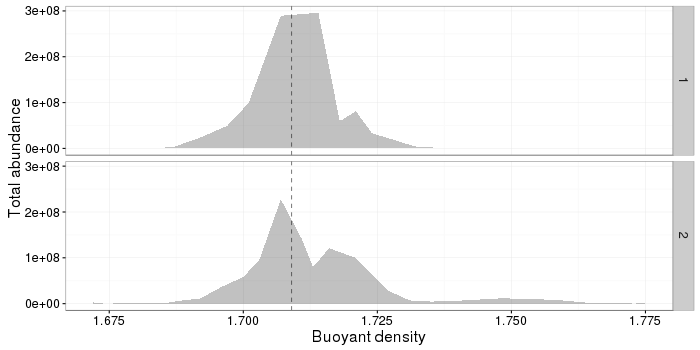

In [302]:
%%R -w 700 -h 350
# plotting absolute abundances

# loading file
df = read.delim('OTU_n2_abs1e9.txt', sep='\t') 

df.s = df %>%
    group_by(library, BD_mid) %>%
    summarize(total_count = sum(count)) 

## plot
p = ggplot(df.s, aes(BD_mid, total_count)) +
    #geom_point() +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Total abundance') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16) 
    )
p

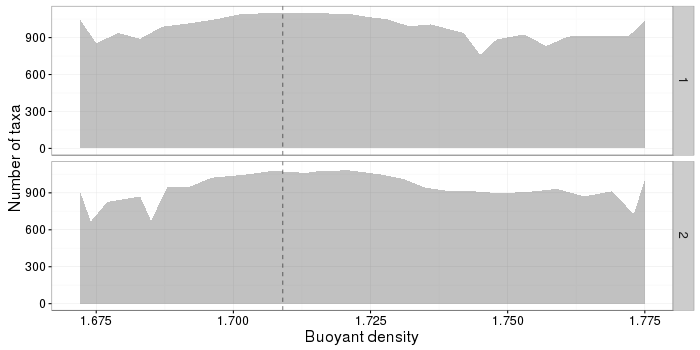

In [303]:
%%R -w 700 -h 350
# plotting number of taxa at each BD

df.nt = df %>%
    filter(count > 0) %>%
    group_by(library, BD_mid) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(df.nt, aes(BD_mid, n_taxa)) +
    #geom_point() +
    geom_area(stat='identity', alpha=0.3, position='dodge') +
    #geom_histogram(stat='identity') +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

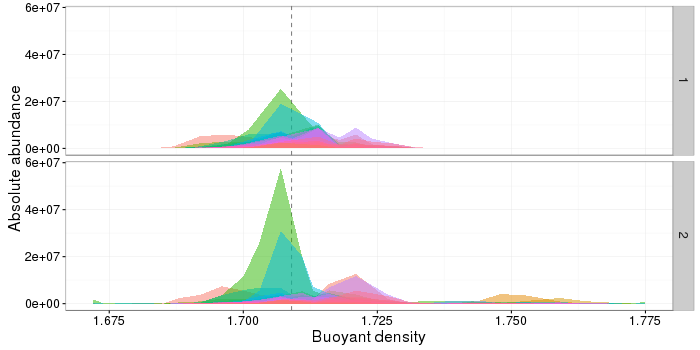

In [304]:
%%R -w 700 -h 350
# plotting relative abundances

## plot
p = ggplot(df, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Absolute abundance') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p + geom_area(stat='identity', position='dodge', alpha=0.5)

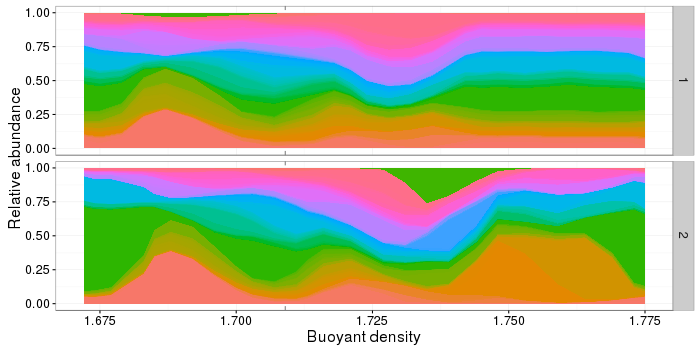

In [305]:
%%R -w 700 -h 350
p + 
    geom_area(stat='identity', position='fill') +
    labs(x='Buoyant density', y='Relative abundance')

# Simulating PCR bias

In [306]:
!SIPSim OTU_PCR \
    OTU_n2_abs1e9.txt \
    --debug \
    > OTU_n2_abs1e9_PCR.txt

## Plotting change in relative abundances

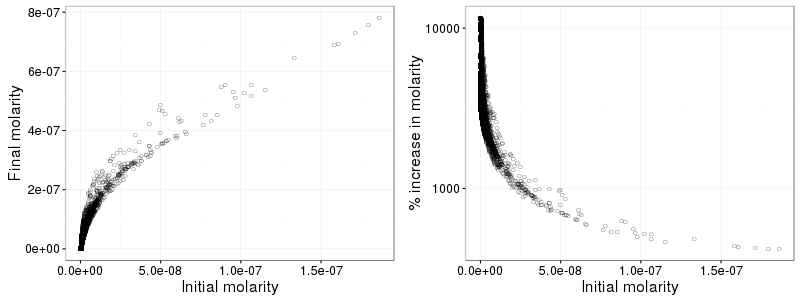

In [307]:
%%R -w 800 -h 300
# loading file
F = 'OTU_n2_abs1e9_PCR.txt'
df.SIM = read.delim(F, sep='\t') %>%
    mutate(molarity_increase = final_molarity / init_molarity * 100)

p1 = ggplot(df.SIM, aes(init_molarity, final_molarity)) +
    geom_point(shape='O', alpha=0.5) +
    labs(x='Initial molarity', y='Final molarity') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

p2 = ggplot(df.SIM, aes(init_molarity, molarity_increase)) +
    geom_point(shape='O', alpha=0.5) +
    scale_y_log10() +
    labs(x='Initial molarity', y='% increase in molarity') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

grid.arrange(p1, p2, ncol=2)

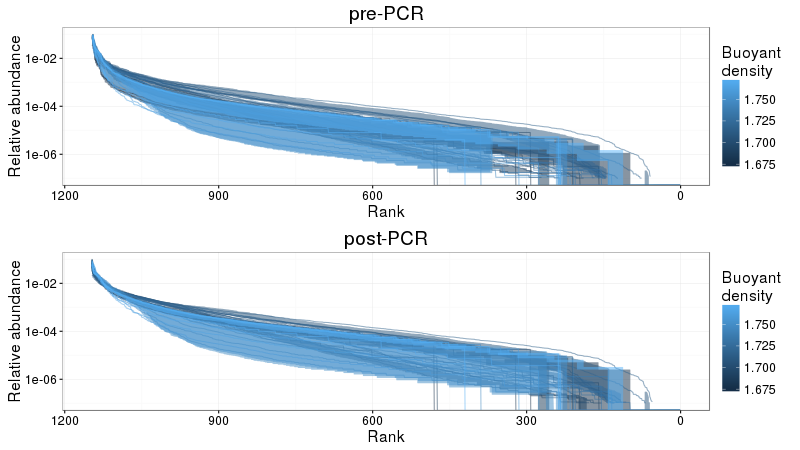

In [308]:
%%R -w 800 -h 450
# plotting rank abundances

df.SIM = df.SIM %>%
    group_by(library, fraction) %>%
    mutate(rel_init_molarity = init_molarity / sum(init_molarity),
           rel_final_molarity = final_molarity / sum(final_molarity),
           init_molarity_rank = row_number(rel_init_molarity),
           final_molarity_rank = row_number(rel_final_molarity)) %>%
    ungroup() 
    

p1 = ggplot(df.SIM, aes(init_molarity_rank, rel_init_molarity, color=BD_mid, group=BD_mid)) +
    geom_line(alpha=0.5) +
    scale_y_log10(limits=c(1e-7, 0.1)) +
    scale_x_reverse() +
    scale_color_gradient('Buoyant\ndensity') +
    labs(x='Rank', y='Relative abundance', title='pre-PCR') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

p2 = ggplot(df.SIM, aes(final_molarity_rank, rel_final_molarity, color=BD_mid, group=BD_mid)) +
    geom_line(alpha=0.5) +
    scale_y_log10(limits=c(1e-7, 0.1)) +
    scale_x_reverse() +
    scale_color_gradient('Buoyant\ndensity') +
    labs(x='Rank', y='Relative abundance', title='post-PCR') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )


grid.arrange(p1, p2, ncol=1)

#### Notes

* The PCR raises the relative abundances most for low-abundance taxa
* Results in a more even rank-abundance distribution

In [309]:
# PCR w/out --debug
!SIPSim OTU_PCR \
    OTU_n2_abs1e9.txt \
    > OTU_n2_abs1e9_PCR.txt

# Subsampling from the OTU table 

* simulating sequencing of the DNA pool

In [310]:
!SIPSim OTU_subsample \
    --dist $subsample_dist \
    --dist_params mean:$subsample_mean,sigma:$subsample_scale \
    --min_size $subsample_min \
    --max_size $subsample_max \
    OTU_n2_abs1e9_PCR.txt \
    > OTU_n2_abs1e9_PCR_subNorm.txt

### Plotting seq count distribution

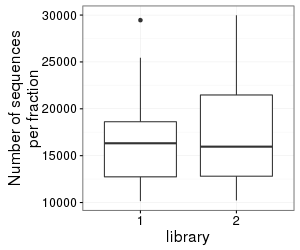

In [311]:
%%R -w 300 -h 250

df = read.csv('OTU_n2_abs1e9_PCR_subNorm.txt', sep='\t')

df.s = df %>% 
    group_by(library, fraction) %>%
    summarize(total_count = sum(count)) %>%
    ungroup() %>%
    mutate(library = as.character(library))

ggplot(df.s, aes(library, total_count)) +
    geom_boxplot() +
    labs(y='Number of sequences\nper fraction') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# Plotting abundance distributions (paper figure)

In [312]:
%%R 

# loading file
df.abs = read.delim('OTU_n2_abs1e9.txt', sep='\t')
df.sub = read.delim('OTU_n2_abs1e9_PCR_subNorm.txt', sep='\t')

lib.reval = c('1' = 'control',
              '2' = 'treatment')

df.abs = mutate(df.abs, library = plyr::revalue(as.character(library), lib.reval))
df.sub = mutate(df.sub, library = plyr::revalue(as.character(library), lib.reval))

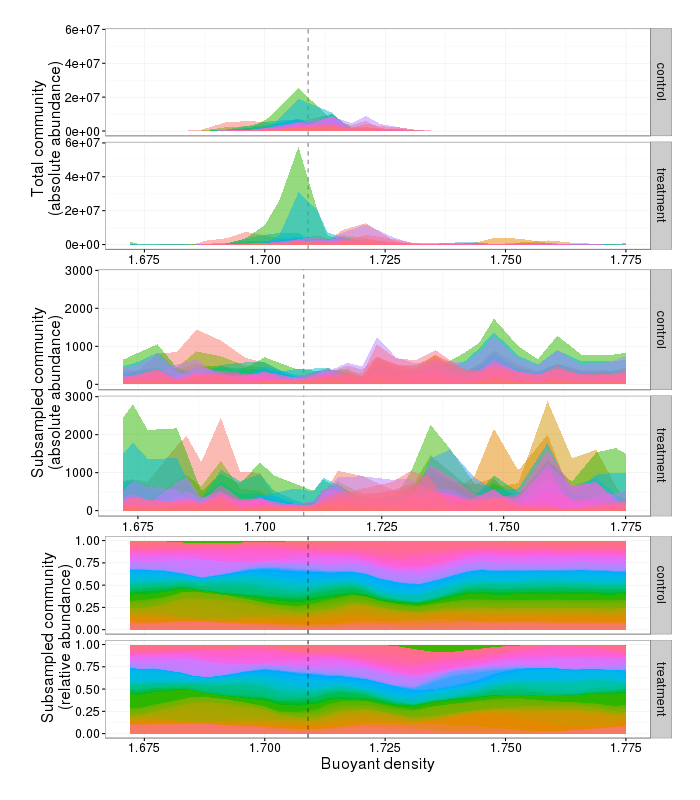

In [313]:
%%R -w 700 -h 800
# plotting absolute abundances
## plot
p = ggplot(df.abs, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank(),
        legend.position = 'none',
        plot.margin=unit(c(1,1,0.1,1), "cm")
    )
p1 = p + geom_area(stat='identity', position='dodge', alpha=0.5) +
    labs(y='Total community\n(absolute abundance)')

# plotting absolute abundances of subsampled
## plot
p = ggplot(df.sub, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p2 = p + geom_area(stat='identity', position='dodge', alpha=0.5) +
    labs(y='Subsampled community\n(absolute abundance)') +
    theme(
          axis.title.y = element_text(vjust=1),        
          axis.title.x = element_blank(),
          plot.margin=unit(c(0.1,1,0.1,1), "cm")
         )

# plotting relative abundances of subsampled
p3 = p + geom_area(stat='identity', position='fill') +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(y='Subsampled community\n(relative abundance)') +
    theme(
          axis.title.y = element_text(vjust=1),
          plot.margin=unit(c(0.1,1,1,1.35), "cm")
        )

# combining plots
grid.arrange(p1, p2, p3, ncol=1)

In [314]:
%%R -i figureDir 
# saving figure

outFile = file.path(figureDir, 'abundDist_example.pdf')

pdf(outFile, width=10.5, height=12)
grid.arrange(p1, p2, p3, ncol=1)
dev.off()

png 
  2 


# Making a wide OTU table

In [315]:
!SIPSim OTU_wideLong -w \
    OTU_n2_abs1e9_PCR_subNorm.txt \
    > OTU_n2_abs1e9_PCR_subNorm_w.txt

# Making metadata (phyloseq: sample_data)

In [316]:
!SIPSim OTU_sampleData \
    OTU_n2_abs1e9_PCR_subNorm.txt \
    > OTU_n2_abs1e9_PCR_subNorm_meta.txt

# Community analysis

## Phyloseq

In [317]:
%%bash -s $workDir
cd $1

export PATH=/home/nick/notebook/SIPSim/lib/R/:$PATH

# making phyloseq object from OTU table
phyloseq_make.r \
    OTU_n2_abs1e9_PCR_subNorm_w.txt \
    -s OTU_n2_abs1e9_PCR_subNorm_meta.txt \
    > OTU_n2_abs1e9_PCR_subNorm.physeq
## making ordination
phyloseq_ordination.r \
    OTU_n2_abs1e9_PCR_subNorm.physeq \
    OTU_n2_abs1e9_PCR_subNorm_bray-NMDS.pdf    
## filtering phyloseq object to just taxa/samples of interest (eg., BD-min/max)
phyloseq_edit.r \
    OTU_n2_abs1e9_PCR_subNorm.physeq \
    --BD_min 1.71 --BD_max 1.75 --occur 0.25 \
    > OTU_n2_abs1e9_PCR_subNorm_filt.physeq
## making ordination
phyloseq_ordination.r \
    OTU_n2_abs1e9_PCR_subNorm_filt.physeq \
    OTU_n2_abs1e9_PCR_subNorm_filt_bray-NMDS.pdf
    
convert OTU_n2_abs1e9_PCR_subNorm_bray-NMDS.pdf OTU_n2_abs1e9_PCR_subNorm_bray-NMDS.png
convert OTU_n2_abs1e9_PCR_subNorm_filt_bray-NMDS.pdf OTU_n2_abs1e9_PCR_subNorm_filt_bray-NMDS.png

Square root transformation
Wisconsin double standardization
Run 0 stress 0.0923008 
Run 1 stress 0.1843356 
Run 2 stress 0.1017705 
Run 3 stress 0.1641825 
Run 4 stress 0.1231433 
Run 5 stress 0.09233594 
... procrustes: rmse 0.004197904  max resid 0.02579375 
Run 6 stress 0.09228791 
... New best solution
... procrustes: rmse 0.003722158  max resid 0.02522469 
Run 7 stress 0.1749667 
Run 8 stress 0.1017699 
Run 9 stress 0.2987482 
Run 10 stress 0.1464152 
Run 11 stress 0.1633911 
Run 12 stress 0.1017699 
Run 13 stress 0.09230081 
... procrustes: rmse 0.003734238  max resid 0.02526022 
Run 14 stress 0.1017701 
Run 15 stress 0.1895677 
Run 16 stress 0.123119 
Run 17 stress 0.1780119 
Run 18 stress 0.1746974 
Run 19 stress 0.1830247 
Run 20 stress 0.1837698 
Square root transformation
Wisconsin double standardization
Run 0 stress 0.04644295 
Run 1 stress 0.04644298 
... procrustes: rmse 4.197673e-05  max resid 0.0001020593 
*** Solution reached


Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Warning messages:
1: In sqrt(x) : NaNs produced
2: Removed 2 rows containing missing values (geom_point). 
Warning messages:
1: In sqrt(x) : NaNs produced
2: Removed 2 rows containing missing values (geom_point). 
Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 


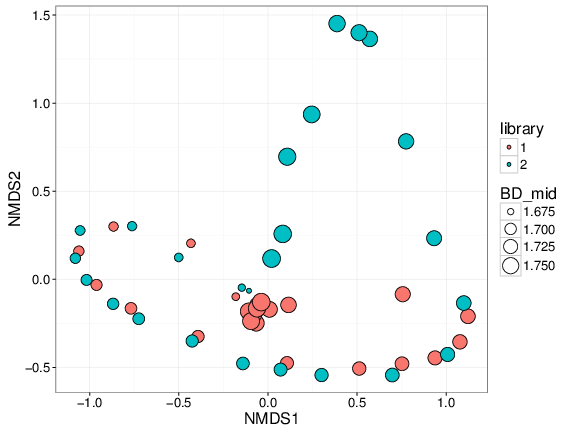

In [318]:
Image(filename='OTU_n2_abs1e9_PCR_subNorm_bray-NMDS.png') 

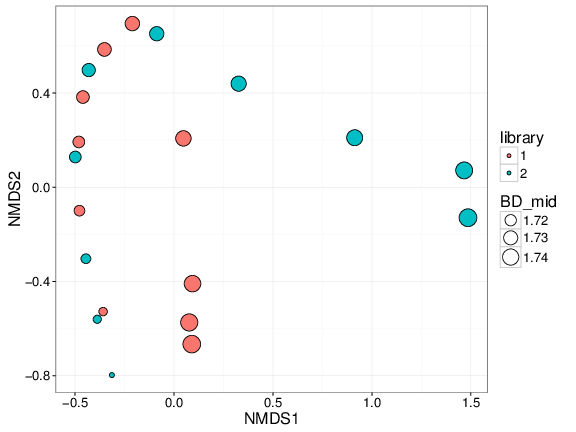

In [319]:
Image(filename='OTU_n2_abs1e9_PCR_subNorm_filt_bray-NMDS.png')

## DESeq2

In [320]:
## DESeq2
!$R_dir/phyloseq_DESeq2.r \
    OTU_n2_abs1e9_PCR_subNorm_filt.physeq \
    --log2 0.25 \
    --hypo greater \
    > OTU_n2_abs1e9_PCR_subNorm_DESeq2
    
## Confusion matrix
!$R_dir/DESeq2_confuseMtx.r \
    ampFrags_BD-shift.txt \
    OTU_n2_abs1e9_PCR_subNorm_DESeq2 \
    --padj 0.1       

Warning messages:
1: replacing previous import by ‘scales::alpha’ when loading ‘phyloseq’ 
2: replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
converting counts to integer mode
Warning message:
In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 24 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
Warning message:
replacing previous import by ‘ggplot2::Position’ when loading ‘DESeq2’ 
Log2Fold cutoff: -Inf
padj cutoff: 0.1
File written: DESeq2-cMtx
File written: DESeq2-cMtx_data.txt
File written: DESeq2-cMtx_table.txt
File written: DESeq2-cMtx_overall.txt
File written: DESeq2-cMtx_byClass

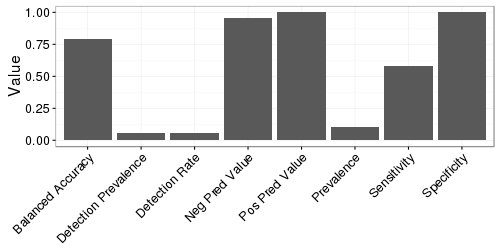

In [321]:
%%R -w 500 -h 250

byClass = read.delim('DESeq2-cMtx_byClass.txt', sep='\t') %>%
    filter(library == 2) 

ggplot(byClass, aes(variables, values)) +
    geom_bar(stat='identity') +
    labs(y='Value') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=45, hjust=1)
    )

## Plotting results of DESeq2

In [322]:
%%R

clsfy = function(guess,known){
    if(is.na(guess) | is.na(known)){
        return(NA)
        }
    if(guess == TRUE){
        if(guess == known){
            return('True positive')
            } else {
            return('False positive')
            }
        } else
    if(guess == FALSE){
        if(guess == known){
            return('True negative')
            } else {
            return('False negative')
            }
        } else {
        stop('Error: true or false needed')
        }
    }

In [323]:
%%R 

df = read.delim('DESeq2-cMtx_data.txt', sep='\t')

df = df %>%
    filter(! is.na(log2FoldChange), library == 2) %>%
    mutate(taxon = reorder(taxon, -log2FoldChange),
           cls = mapply(clsfy, incorp.pred, incorp.known))

df %>% head(n=3)

  library                                taxon min q25 mean median q75 max
1       2 Acetobacter_pasteurianus_IFO_3283-03   0   0    0      0   0   0
2       2       Acetobacterium_woodii_DSM_1030   0   0    0      0   0   0
3       2    Acetohalobium_arabaticum_DSM_5501   0   0    0      0   0   0
    baseMean log2FoldChange    lfcSE      stat    pvalue      padj         p
1 5.96040160      0.3739965 1.041209 0.1190889 0.4526025 0.9998771 0.4526025
2 1.33269066     -0.9683018 1.080710 0.0000000 0.8701956 0.9998771 0.8701956
3 0.09372106     -0.8294875 2.046666 0.0000000 0.7010549 0.9998771 0.7010549
    padj.BH incorp.known incorp.pred           cls
1 0.9998771        FALSE       FALSE True negative
2 0.9998771        FALSE       FALSE True negative
3 0.9998771        FALSE       FALSE True negative


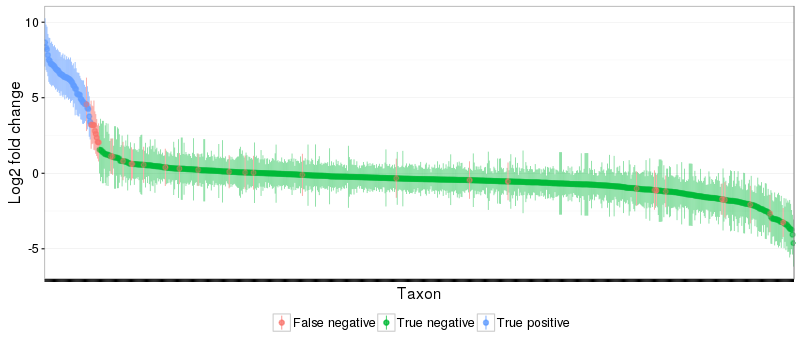

In [324]:
%%R -w 800 -h 350

df.TN = df %>% filter(cls == 'True negative')
df.TP = df %>% filter(cls == 'True positive')
df.FP = df %>% filter(cls == 'False negative')

ggplot(df, aes(taxon, log2FoldChange, color=cls, 
                  ymin=log2FoldChange - lfcSE, ymax=log2FoldChange + lfcSE)) +
    geom_pointrange(size=0.4, alpha=0.5) +
    geom_pointrange(data=df.TP, size=0.4, alpha=0.3) +
    geom_pointrange(data=df.FP, size=0.4, alpha=0.3) +
    labs(x = 'Taxon', y = 'Log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),        
        legend.title=element_blank(),
        axis.text.x = element_blank(),
        legend.position = 'bottom'
        )

In [325]:
%%R -i figureDir

outFile = paste(c(figureDir, 'l2fc_example.pdf'), collapse='/')
ggsave(outFile, width=10, height=4)

__Notes:__

* Red circles = true positives

* False positives should increase with taxon GC 
  * Higher GC moves 100% incorporators too far to the right the gradient for the 'heavy' BD range of 1.71-1.75
* Lines indicate standard errors.

# sensitivity ~ pre-frac relative_abundance

* **Enrichment of TP for abundant incorporators?**

* What is the abundance distribution of TP and FP?
  * Are more abundant incorporators being detected more than low abundant taxa

In [329]:
%%R
df.ds = read.delim('DESeq2-cMtx_data.txt', sep='\t') 
df.comm = read.delim('comm.txt', sep='\t')

df.j = inner_join(df.ds, df.comm, c('taxon' = 'taxon_name',
                                    'library' = 'library'))

df.ds = df.comm = NULL
df.j %>% head(n=3)

  library                                taxon          min          q25
1       1 Acetobacter_pasteurianus_IFO_3283-03 1.598721e-14 1.731948e-14
2       1       Acetobacterium_woodii_DSM_1030 2.531308e-14 2.797762e-14
3       1    Acetohalobium_arabaticum_DSM_5501 3.330669e-15 1.088019e-14
          mean       median          q75          max   baseMean log2FoldChange
1 1.872619e-14 1.865175e-14 2.020606e-14 2.153833e-14 5.96040160      0.3739965
2 3.061511e-14 3.064216e-14 3.330669e-14 3.597123e-14 1.33269066     -0.9683018
3 1.827651e-14 1.820766e-14 2.575717e-14 3.330669e-14 0.09372106     -0.8294875
     lfcSE      stat    pvalue      padj         p   padj.BH incorp.known
1 1.041209 0.1190889 0.4526025 0.9998771 0.4526025 0.9998771        FALSE
2 1.080710 0.0000000 0.8701956 0.9998771 0.8701956 0.9998771        FALSE
3 2.046666 0.0000000 0.7010549 0.9998771 0.7010549 0.9998771        FALSE
  incorp.pred rel_abund_perc rank
1       FALSE    0.009764492  666
2       FALSE    0.47249

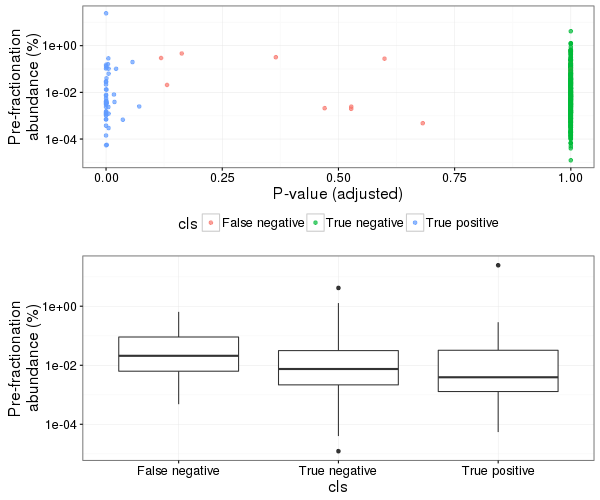

In [330]:
%%R -h 500 -w 600

df.j.f = df.j %>%
    filter(! is.na(log2FoldChange),
           library == 2) %>%
    mutate(cls = mapply(clsfy, incorp.pred, incorp.known)) 

y.lab = 'Pre-fractionation\nabundance (%)'
p1 = ggplot(df.j.f, aes(padj, rel_abund_perc, color=cls)) +
    geom_point(alpha=0.7) +
    scale_y_log10() +
    labs(x='P-value (adjusted)', y=y.lab) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'bottom'
    )

p2 = ggplot(df.j.f, aes(cls, rel_abund_perc)) +
    geom_boxplot() +
    scale_y_log10() +
    labs(y=y.lab) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

grid.arrange(p1, p2, ncol=1)

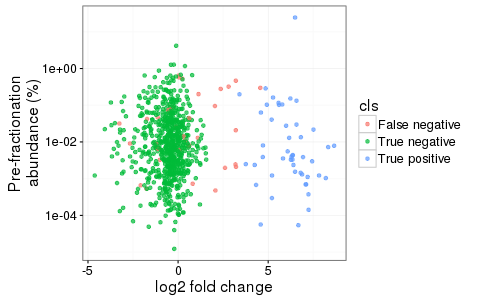

In [331]:
%%R -h 300
# plotting
ggplot(df.j.f, aes(log2FoldChange, rel_abund_perc, color=cls)) +
    geom_point(alpha=0.7) +
    scale_y_log10() +
    labs(x='log2 fold change', y=y.lab) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )


***

# --OLD--

In [225]:
%%R 

df.ds = read.csv('DESeq2-cMtx_data.txt', sep='\t') %>%
    filter(library == 2) %>%
    select(-library)

# loading file
df.otu = read.delim('OTU_n2_abs1e9_PCR_subNorm.txt', sep='\t') %>%
    filter(BD_min >= 1.71, BD_max <= 1.75) %>%
    group_by(library, taxon) %>%
    mutate(min_rel_abund = min(rel_abund),
           mean_rel_abund = mean(rel_abund)) %>%
    ungroup() %>%
    distinct(library, taxon) 

df.j = inner_join(df.otu, df.ds, c('taxon' = 'taxon'))
df.j %>% head(n=3) %>% as.data.frame

  library    fraction                                taxon BD_min BD_mid BD_max
1       1 1.711-1.714       Acaryochloris_marina_MBIC11017  1.711  1.712  1.714
2       2 1.714-1.717       Acaryochloris_marina_MBIC11017  1.714  1.716  1.717
3       1 1.711-1.714 Acetobacter_pasteurianus_IFO_3283-03  1.711  1.712  1.714
  count    rel_abund min_rel_abund mean_rel_abund min q25 mean median q75 max
1     4 0.0002638522             0   4.121498e-05   0   0    0      0   0   0
2     0 0.0000000000             0   0.000000e+00   0   0    0      0   0   0
3    15 0.0009894459             0   1.429122e-04   0   0    0      0   0   0
   baseMean log2FoldChange    lfcSE      stat    pvalue      padj         p
1 0.3793662     0.49874882 1.509085 0.1648342 0.4345372 0.9999998 0.4345372
2 0.3793662     0.49874882 1.509085 0.1648342 0.4345372 0.9999998 0.4345372
3 0.8385490    -0.02196255 1.267655 0.0000000 0.5849370 0.9999998 0.5849370
    padj.BH incorp.known incorp.pred
1 0.9999998        FALSE   

In [201]:
%%R
# classifying
df.j.f = df.j %>%
    filter(! is.na(log2FoldChange)) %>%
    mutate(cls = mapply(clsfy, incorp.pred, incorp.known)) %>%
    filter(cls != 'True negative')

In [202]:
%%R
df.L1 = df.j.f %>% filter(library == 1) %>%
    dplyr::select(taxon, min_rel_abund, mean_rel_abund, log2FoldChange, cls) #%>%
#    rename('lib1_mean_rel_abund' = mean_rel_abund)
df.L2 = df.j.f %>% filter(library == 2) %>%
    dplyr::select(taxon, min_rel_abund, mean_rel_abund, log2FoldChange, cls) #%>%
#    rename('lib2_mean_rel_abund' = mean_rel_abund)
df.j = inner_join(df.L1, df.L2, c('taxon' = 'taxon'))

df.j %>% head(n=3) %>% as.data.frame

                              taxon min_rel_abund.x mean_rel_abund.x
1          Acholeplasma_palmae_J233    0.000000e+00     1.116263e-03
2 Acidithiobacillus_ferrivorans_SS3    4.673116e-05     1.207703e-03
3         Alcanivorax_dieselolei_B5    0.000000e+00     1.890816e-05
  log2FoldChange.x          cls.x min_rel_abund.y mean_rel_abund.y
1         5.294662  True positive               0     1.885555e-02
2         1.976577 False negative               0     1.324440e-03
3         3.378190  True positive               0     3.685784e-05
  log2FoldChange.y          cls.y
1         5.294662  True positive
2         1.976577 False negative
3         3.378190  True positive


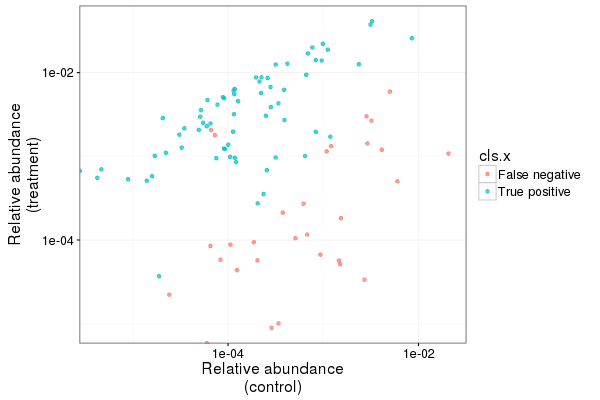

In [203]:
%%R -w 600 -h 400

ggplot(df.j, aes(mean_rel_abund.x, mean_rel_abund.y, color=cls.x)) +
    geom_point(alpha=0.7) +
    #geom_density2d() +
    scale_x_log10() +
    scale_y_log10() +
    labs(x = 'Relative abundance\n(control)', y='Relative abundance\n(treatment)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

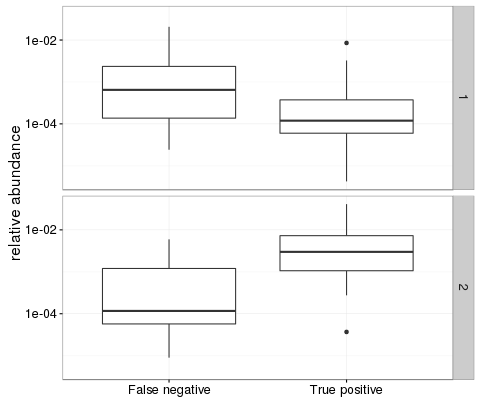

In [204]:
%%R -h 400
ggplot(df.j.f, aes(cls, mean_rel_abund)) +
    geom_boxplot() +
    scale_y_log10() +
    labs(y='relative abundance') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank()
    )

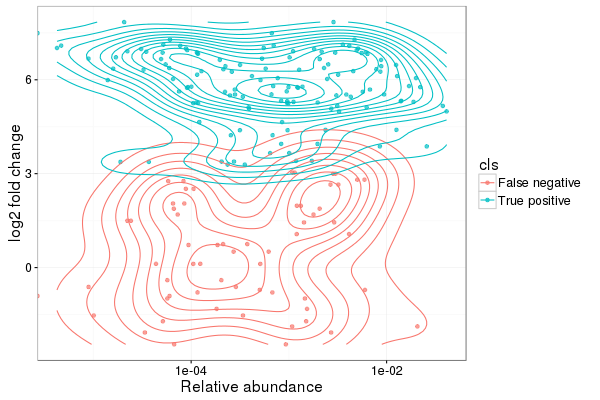

In [205]:
%%R -w 600 -h 400

ggplot(df.j.f, aes(mean_rel_abund, log2FoldChange, color=cls)) +
    geom_point(alpha=0.7) +
    geom_density2d() +
    scale_x_log10() +
    labs(x = 'Relative abundance', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

#### Notes:

* More false negatives with lower relative abundance in the BD window

### biserial correlation

In [206]:
%%R
library(ltm)

levs = c('True positive', 'False negative')

df.j.f %>%
    mutate(cls = factor(cls, levels=levs)) %>%
    group_by(library) %>%
    summarize(biserial_cor = biserial.cor(mean_rel_abund, cls))

Source: local data frame [2 x 2]

  library biserial_cor
    (int)        (dbl)
1       1   -0.2789406
2       2    0.3426538


### t-test

In [207]:
%%R
t.test(mean_rel_abund ~ cls, data=df.j.f)


	Welch Two Sample t-test

data:  mean_rel_abund by cls
t = -2.9055, df = 191.99, p-value = 0.004097
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.0033042348 -0.0006320861
sample estimates:
mean in group False negative  mean in group True positive 
                 0.001378397                  0.003346558 



# sensitivity ~ pre-frac_abundance

* **Enrichment of TP for abundant incorporators?**

* What is the abundance distribution of TP and FP?
  * Are more abundant incorporators being detected more than low abundant taxa

In [208]:
%%R -i workDir

setwd(workDir)

df.ds = read.csv('DESeq2-cMtx_data.csv')

df.comm = read.delim('comm.txt', sep='\t') %>%
    mutate(rel_abund_perc = rel_abund_perc / 100) %>%
    rename('preFrac_rel_abund' = rel_abund_perc) 

df.j = inner_join(df.ds, df.comm, c('taxon' = 'taxon_name'))
df.j %>% head(n=3)

  lib1 lib2                         taxon  BD_shift    baseMean log2FoldChange
1   NA    2 Sorangium_cellulosum_So0157-2 0.9963747 218.8319203      -1.877790
2   NA    2 Sorangium_cellulosum_So0157-2 0.9963747 218.8319203      -1.877790
3   NA    2       Bacillus_subtilis_QB928 0.0000000   0.3006038      -1.406633
     lfcSE stat    pvalue      padj         p   padj.BH incorp.known
1 1.149307    0 0.9679416 0.9998523 0.9679416 0.9998523         TRUE
2 1.149307    0 0.9679416 0.9998523 0.9679416 0.9998523         TRUE
3 1.402593    0 0.8812229 0.9998523 0.8812229 0.9998523        FALSE
  incorp.pred library preFrac_rel_abund rank
1       FALSE       1      0.0047102422   40
2       FALSE       2      0.0042019872   40
3       FALSE       1      0.0001065102  629


In [209]:
%%R
# classifying
df.j.f = df.j %>%
    filter(! is.na(log2FoldChange)) %>%
    mutate(cls = mapply(clsfy, incorp.pred, incorp.known)) %>%
    filter(cls != 'True negative',
           library == 2)
df.j.f %>% head(n=3)

  lib1 lib2                            taxon  BD_shift  baseMean log2FoldChange
1   NA    2    Sorangium_cellulosum_So0157-2 0.9963747 218.83192      -1.877790
2   NA    2  Haemophilus_parainfluenzae_T3T1 0.9962400  17.37230       6.717741
3   NA    2 Robiginitalea_biformata_HTCC2501 0.9963355  97.49932       5.529269
     lfcSE     stat       pvalue         padj            p      padj.BH
1 1.149307 0.000000 9.679416e-01 9.998523e-01 9.679416e-01 9.998523e-01
2 1.326389 4.876204 5.407352e-07 3.399422e-05 5.407352e-07 3.399422e-05
3 1.393271 3.789118 7.559160e-05 1.344960e-03 7.559160e-05 1.344960e-03
  incorp.known incorp.pred library preFrac_rel_abund rank            cls
1         TRUE       FALSE       2      4.201987e-03   40 False negative
2         TRUE        TRUE       2      1.803508e-05  914  True positive
3         TRUE        TRUE       2      2.380784e-04  378  True positive


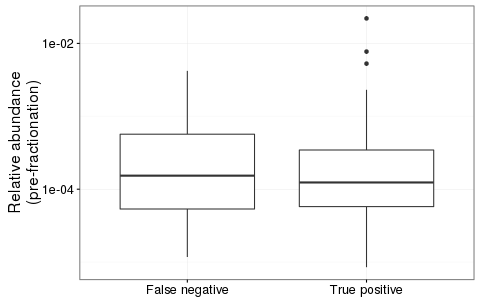

In [210]:
%%R -h 300

ggplot(df.j.f, aes(cls, preFrac_rel_abund)) +
    geom_boxplot() +
    scale_y_log10() +
    labs(y='Relative abundance\n(pre-fractionation)') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank()
    )

#### Notes:

* pre-fractionation abundance does matter for sensitivity

# Plotting abundance distribution of True Positive taxa (actual incorporators) 

In [211]:
%%R -i workDir -w 1000 -h 450
setwd(workDir)

df.ds = read.csv('DESeq2-cMtx_data.csv')

# loading file
df.otu = read.delim('OTU_n2_abs1e9_PCR_subNorm.txt', sep='\t')
#df.otu = read.delim('OTU_n2_abs1e9.txt', sep='\t')

df.j = inner_join(df.otu, df.ds, c('taxon' = 'taxon'))

# edit
lib.reval = c('1' = 'control',
              '2' = 'treatment')

df.j = mutate(df.j, library = plyr::revalue(as.character(library), lib.reval))

df.j %>% head(n=3)

    library    fraction                          taxon BD_min BD_mid BD_max
1   control  -inf-1.660 Acaryochloris_marina_MBIC11017   -Inf  1.659  1.659
2 treatment  -inf-1.660 Acaryochloris_marina_MBIC11017   -Inf  1.659  1.659
3   control 1.660-1.663 Acaryochloris_marina_MBIC11017   1.66  1.661  1.663
  count   rel_abund lib1 lib2 BD_shift baseMean log2FoldChange     lfcSE stat
1    51 0.001646223   NA    2        0 3.751202     -0.5731145 0.9246022    0
2    26 0.001374425   NA    2        0 3.751202     -0.5731145 0.9246022    0
3    16 0.001058271   NA    2        0 3.751202     -0.5731145 0.9246022    0
     pvalue      padj         p   padj.BH incorp.known incorp.pred
1 0.8133305 0.9998523 0.8133305 0.9998523        FALSE       FALSE
2 0.8133305 0.9998523 0.8133305 0.9998523        FALSE       FALSE
3 0.8133305 0.9998523 0.8133305 0.9998523        FALSE       FALSE


In [212]:
%%R
# DESeq2 params
BD.win.min = 1.71
BD.win.max = 1.75

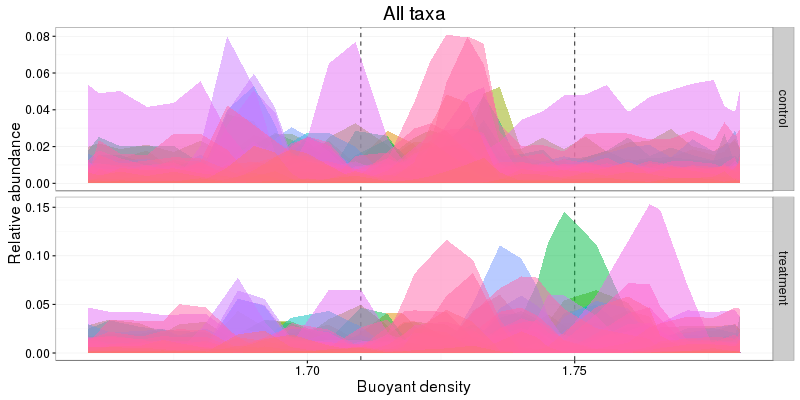

In [213]:
%%R -w 800 -h 400
# plotting relative abundances: all
## plot
p = ggplot(df.j, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_vline(xintercept=c(BD.win.min, BD.win.max), linetype='dashed', alpha=0.8) +
    labs(x='Buoyant density', y='Relative abundance', title='All taxa') +
    facet_grid(library ~ ., scales='free_y') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p = p + geom_area(stat='identity', position='dodge', alpha=0.5)
p

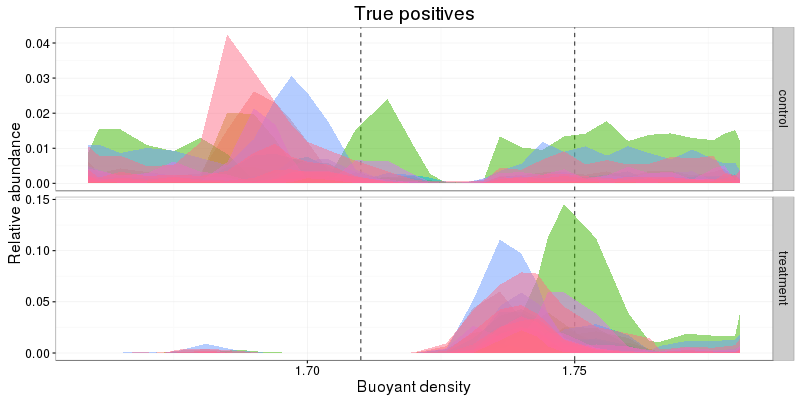

In [214]:
%%R -w 800 -h 400
# plotting relative abundances

df.j.TP = df.j %>% 
    filter(incorp.known == TRUE & incorp.pred == TRUE) 


## plot
p = ggplot(df.j.TP, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_vline(xintercept=c(BD.win.min, BD.win.max), linetype='dashed', alpha=0.8) +
    labs(x='Buoyant density', y='Relative abundance', title='True positives') +
    facet_grid(library ~ ., scales='free_y') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p1 = p + geom_area(stat='identity', position='dodge', alpha=0.5)
p1

# Plotting abundance distribution of False Negative taxa (actual incorporators) 

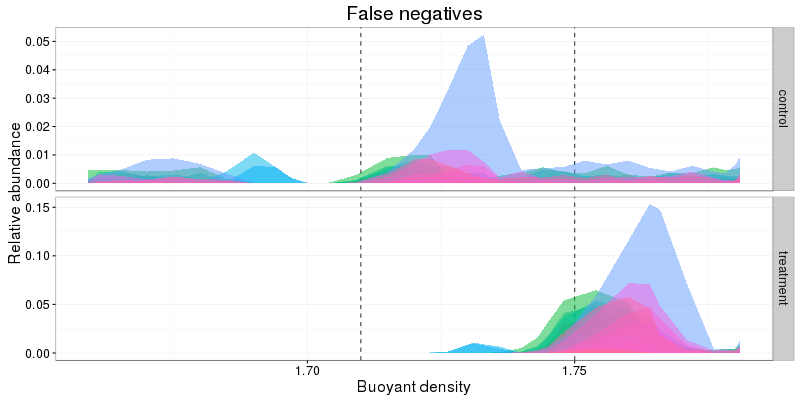

In [215]:
%%R -w 800 -h 400
# plotting relative abundances

df.j.FN = df.j %>% 
    filter(incorp.known == TRUE & incorp.pred == FALSE) 

## plot
p = ggplot(df.j.FN, aes(BD_mid, rel_abund, fill=taxon)) +
    geom_vline(xintercept=c(BD.win.min, BD.win.max), linetype='dashed', alpha=0.8) +
    labs(x='Buoyant density', y='Relative abundance', title='False negatives') +
    facet_grid(library ~ ., scales='free_y') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p2 = p + geom_area(stat='identity', position='dodge', alpha=0.5)
p2

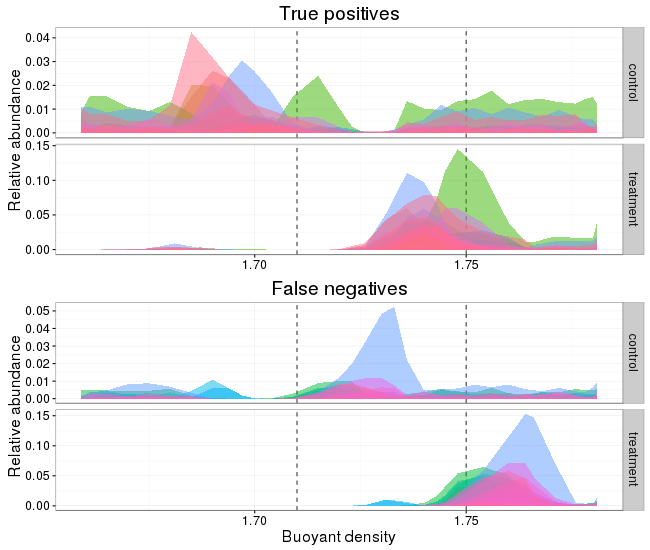

In [216]:
%%R -i figureDir -h 550 -w 650

outFile = paste(c(figureDir, 'abundDist_TP-FN_example.pdf'), collapse='/')

p1.e = p1 + theme(axis.title.x = element_blank())

pdf(outFile, width=13, height=11)
grid.arrange(p1.e, p2, ncol=1)
dev.off()

grid.arrange(p1.e, p2, ncol=1)

## Conclusions

* For 100% incorporation, the 'heavy' BD range of 1.71-1.75 does not encompass most of the incorporator abundance.
  * This results in negative log2fc

## Indy taxa BD shift plots

In [217]:
%%R
# checking on number of incorporators
df.j %>% filter(BD_shift > 0.05) %>% distinct(taxon) %>% nrow %>% print
df.j %>% filter(incorp.known == TRUE) %>% distinct(taxon) %>% nrow %>% print

[1] 97
[1] 97


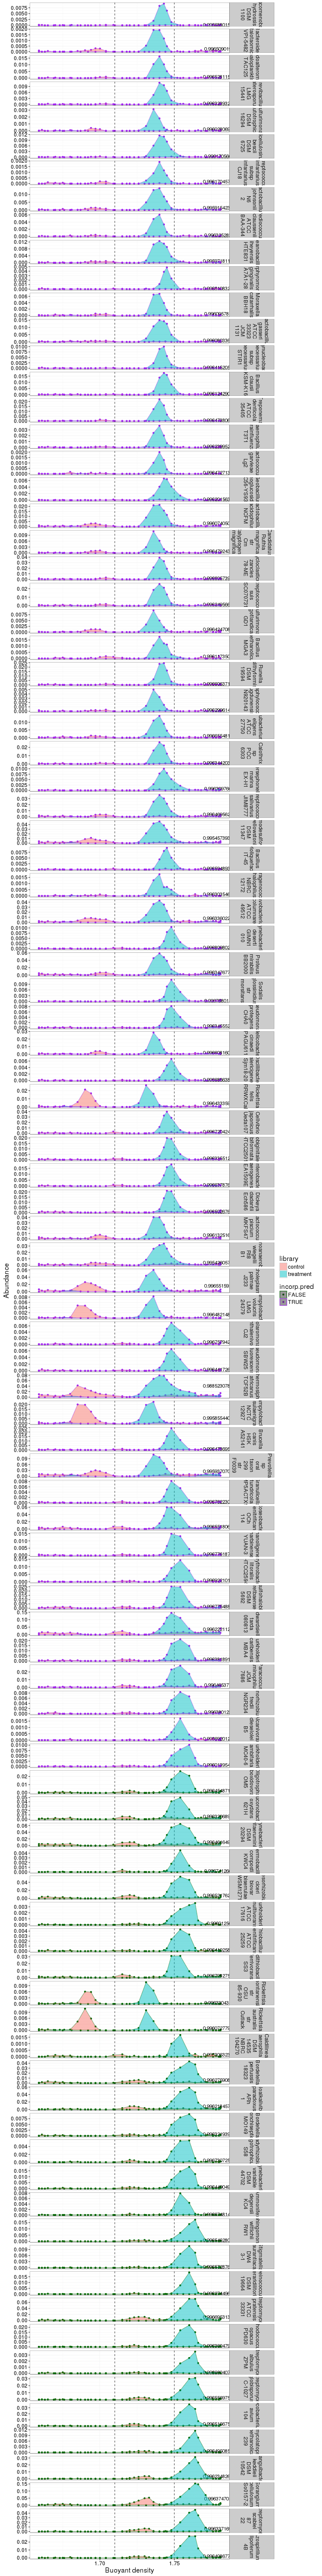

In [218]:
%%R -w 750 -h 6000
# plotting relative abundances

df.j.f = df.j %>%
    filter(incorp.known == TRUE) %>%
    mutate(taxon= gsub('_', '\n', taxon))
           
df.j.f$taxon = reorder(df.j.f$taxon, -df.j.f$log2FoldChange)

quant = function(x, p=0.95){
    x = x %>% as.numeric
    return(quantile(x, probs=c(0.9))[1] %>% as.numeric)
}

df.j.f.txt = df.j.f %>%
    group_by(taxon, BD_shift) %>%
    summarize(BD_mid = max(BD_mid),
              count = quant(count),
              rel_abund = quant(rel_abund)) %>%
    ungroup() 


## plot
p = ggplot(df.j.f, aes(BD_mid, rel_abund)) +
    geom_point(aes(color=incorp.pred)) +
    geom_text(data=df.j.f.txt, aes(label=BD_shift)) +
    scale_color_manual(values=c('darkgreen', 'purple')) +
    geom_vline(xintercept=c(BD.win.min, BD.win.max), linetype='dashed', alpha=0.8) +
    labs(x='Buoyant density', y='Abundance') +
    facet_grid(taxon ~ ., scale='free_y') +
    theme_bw() +
    theme( 
        text = element_text(size=16)
    )

p2 = p + geom_area(stat='identity', position='dodge', alpha=0.5, aes(fill=library, color=incorp.pred))
p2